In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


## word-level speaker related feature extraction

In [3]:
import itertools
import torch

def load_pretrained_model(config, pretrained_path, ):
    pre_state = torch.load(pretrained_path)
#     fine_tuned_params = ['output.weight', 'output.bias']
    pre_trained_state = {k: v for k, v in pre_state.items()}

    new_si_model = config['model_class'](config)
    new_state = new_si_model.state_dict()
    new_state.update(pre_trained_state)
    new_si_model.load_state_dict(new_state)  
    
    for param in new_si_model.parameters():
        param.requires_grad = False
        
#     for param in itertools.chain(new_si_model.output.parameters()):
#         param.requires_grad = True
    return new_si_model

In [4]:
import honk_sv.train as hk
from honk_sv import model as mod

In [5]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
command_df = pd.read_pickle(os.path.join(dataframe_dir,'Command_Dataframe.pkl'))

In [6]:
pick_words = ["yes", "no", "up", "down"]

In [7]:
#TODO: correct splits
all_spks = command_df.spk.unique()
all_words= command_df.sent.unique()
uttrs_counts = command_df.spk.value_counts()
sv_spks = list(uttrs_counts[:10].index)  # top 10 speakers whose number of recored uttrs is high
si_df = command_df[(~command_df.spk.isin(sv_spks))&(command_df.sent.isin(pick_words))]
si_spks = list(si_df.spk.unique())
sv_df = command_df[(command_df.spk.isin(sv_spks))&(command_df.sent.isin(pick_words))]
unknown_si_df = command_df[(command_df.spk.isin(si_spks)) & (~command_df.sent.isin(pick_words))]

In [8]:
import random 

si_train = dict()
si_val = dict()
si_test = dict()

for word in pick_words:
    word_df = si_df[si_df.sent == word]
    si_train[word] = word_df.sample(frac=0.8)
    si_val[word] = word_df.drop(index=si_train[word].index)
    si_test[word] = si_val[word]

In [15]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_train, 'val':si_val, 'test':si_test}
manifest_dir = "manifests/commands/word"
if not os.path.exists(manifest_dir):
    os.makedirs(manifest_dir)
    
for word in pick_words:
    for tag in tags:
        samples = []
        save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format(word, tag))
        with open(save_path, 'w') as f:
            for index, row in sets[tag][word].iterrows():
                file_path = os.path.join(data_dir, row.sent, row.file)
                label = row.label
                sample = ','.join([file_path, str(label)])
                samples.append(sample)
#             unknown_samples = unknown_si_df.sample(n=len(sample))
#             for index, row in unknown_samples.iterrows():
#                 file_path = os.path.join(data_dir, row.sent, row.file)
#                 label = 0
#                 sample = ','.join([file_path, str(label)])
#                 samples.append(sample)
            random.shuffle(samples)
            writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
            writer.writerow(samples)
            print("{} was written".format(save_path))

manifests/commands/word/si_yes_train_manifest.csv was written
manifests/commands/word/si_yes_val_manifest.csv was written
manifests/commands/word/si_yes_test_manifest.csv was written
manifests/commands/word/si_no_train_manifest.csv was written
manifests/commands/word/si_no_val_manifest.csv was written
manifests/commands/word/si_no_test_manifest.csv was written
manifests/commands/word/si_up_train_manifest.csv was written
manifests/commands/word/si_up_val_manifest.csv was written
manifests/commands/word/si_up_test_manifest.csv was written
manifests/commands/word/si_down_train_manifest.csv was written
manifests/commands/word/si_down_val_manifest.csv was written
manifests/commands/word/si_down_test_manifest.csv was written


In [9]:
model = "cnn-trad-pool2"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=16, print_step=200,
                )

In [10]:
builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
si_config['n_feature_maps1'] = 64
hk.set_seed(si_config)

In [11]:
si_config['n_labels'] = 2000
si_config['batch_size'] = 32
si_config['n_epochs'] = 30
si_config['lr'] = [0.001, 0.0001]
si_config['schedule'] = [1000]
si_config['bn_size'] = 256

In [38]:
manifest_dir = "./manifests/commands/word/"
for word in pick_words:
    print("########### training {} word ##########".format(word))
    for tag in ['train', 'val', 'test']:
        si_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format(word, tag))
    si_model = load_pretrained_model("models/si_command_sent_model.pt")
    si_config['output_file'] = "models/si_{}_model.pt".format(word)
    hk.train(si_config, model=si_model)

########### training yes word ##########
epoch #0, final dev accuracy: 0.07351190476190476
saving best model...
epoch #1, final dev accuracy: 0.22142857142857145
saving best model...
epoch #2, final dev accuracy: 0.3273809523809524
saving best model...
train step #199 accuracy: 0.96875, loss: 0.2874186336994171
epoch #3, final dev accuracy: 0.39017857142857143
saving best model...
epoch #4, final dev accuracy: 0.40208333333333335
saving best model...
epoch #5, final dev accuracy: 0.4330357142857143
saving best model...
train step #399 accuracy: 0.96875, loss: 0.09429645538330078
epoch #6, final dev accuracy: 0.40773809523809523
epoch #7, final dev accuracy: 0.4238095238095238
epoch #8, final dev accuracy: 0.42291666666666666
epoch #9, final dev accuracy: 0.42886904761904765
train step #599 accuracy: 1.0, loss: 0.004308730363845825
epoch #10, final dev accuracy: 0.4270833333333333
epoch #11, final dev accuracy: 0.44523809523809527
saving best model...
epoch #12, final dev accuracy: 0.43

epoch #15, final dev accuracy: 0.44090909090909086
epoch #16, final dev accuracy: 0.4287878787878788
train step #999 accuracy: 1.0, loss: 0.0021150708198547363
changing learning rate to 0.0001
epoch #17, final dev accuracy: 0.43503787878787875
epoch #18, final dev accuracy: 0.45492424242424245
saving best model...
epoch #19, final dev accuracy: 0.45511363636363633
saving best model...
epoch #20, final dev accuracy: 0.45530303030303027
saving best model...
train step #1199 accuracy: 1.0, loss: 0.0019606947898864746
epoch #21, final dev accuracy: 0.45530303030303027
epoch #22, final dev accuracy: 0.46325757575757576
saving best model...
epoch #23, final dev accuracy: 0.44943181818181815
train step #1399 accuracy: 1.0, loss: 0.0023224949836730957
epoch #24, final dev accuracy: 0.4634469696969697
saving best model...
epoch #25, final dev accuracy: 0.4575757575757576
epoch #26, final dev accuracy: 0.4535984848484848
epoch #27, final dev accuracy: 0.4575757575757576
train step #1599 accuracy

In [12]:
# load models
models = dict.fromkeys(pick_words+["command_random", 'command_sent'])
for key in models.keys():
    model = si_config['model_class'](si_config)
    model.load("models/si_{}_model.pt".format(key))
    models[key] = model

***
### Check the quality of models

In [35]:
# cross check
si_model = models['yes']
si_config['test_manifest'] = "manifests/commands/word/si_down_test_manifest.csv"
hk.evaluate(si_config,si_model)

final test accuracy: 0.16339869281045752


In [46]:
from scipy.spatial.distance import cosine
import random
import itertools

for dirpath, dir, files in os.walk("/home/muncok/DL/dataset/SV_sets/speech_commands/down"):
    neg_pairs = list(itertools.combinations(files, 2))
    neg_pairs = random.choices(pos_pairs, k=1000)        

In [387]:
from collections import defaultdict
scores = defaultdict(list)

In [389]:
best_model = dict.fromkeys(models.keys(), 0)
for a, b in neg_pairs:
    if a.split('_')[0] == b.split('_')[0]:
        # positive pair
        continue
    best_score = 1
    for model in models.keys():
        si_model = models[model]
        path1 = os.path.join(dirpath, a)
        path2 = os.path.join(dirpath, b)
        embed1 = hk.embed(si_config, si_model, path1)
        embed2 = hk.embed(si_config, si_model, path2)
        score = 1 - cosine(embed1, embed2)
        scores[model].append(score)
        if score < best_score:
            best_word = model
            best_score = score
    best_model[best_word] += 1
print(best_model)    

{'yes': 69, 'no': 177, 'up': 113, 'down': 215, 'command_random': 273, 'command_sent': 153}


(array([  14.,   91.,   81.,  216.,  147.,  145.,  107.,  132.,   42.,   25.]),
 array([-0.23970045, -0.17528329, -0.11086614, -0.04644898,  0.01796818,
         0.08238534,  0.1468025 ,  0.21121965,  0.27563681,  0.34005397,
         0.40447113]),
 <a list of 10 Patch objects>)

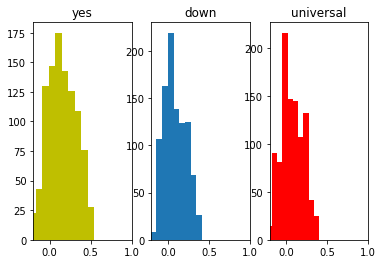

In [394]:
subplot(131)
plt.xlim([-0.2, 1.0])
plt.title("yes")
plt.hist(scores['yes'], color='y')
subplot(132)
plt.xlim([-0.2, 1.0])
plt.title("down")
plt.hist(scores['down'])
subplot(133)
plt.xlim([-0.2, 1.0])
plt.title("universal")
plt.hist(scores['command_random'], color='r')

***
## Verification Learning

In [287]:
sv_spks = list(sv_df.spk.unique())
random.shuffle(sv_spks)
enroll_spks = sv_spks[:3]
test_spks = sv_spks[3:]
# sv_df was too small, so includes utterances not using pick_word
sv_df = command_df[(command_df.spk.isin(sv_spks))]

In [291]:
import random 

sv_train = dict()
sv_val = dict()
sv_test = dict()

# labelded to 1
# it should not include dev_uttrs (saved to evaluate)
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    sv_train[spk] = spk_df.sample(frac=0.8)
    sv_val[spk] = spk_df.drop(index=sv_train[spk].index)
    sv_test[spk] = sv_val[spk]

# labelded to 0
sv_unknown_df = command_df[(command_df.spk.isin(test_spks))]
unknown_train = sv_unknown_df.sample(frac=0.8)
unknown_val = sv_unknown_df.drop(index=unknown_train.index)
unknown_test = unknown_val

### enrollment

In [294]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.8

for spk in enroll_spks:
    enls = sv_train[spk].sample(n=20)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
# splits enroll and dev
# for spk in enroll_spks:
#     spk_df = sv_df[sv_df.spk == spk]
#     assert(len(spk_df) != 0)
#     for sent in pick_words:
#         sent_uttrs = spk_df[spk_df.sent == sent]
#         if len(sent_uttrs) < 2:
#             enls = sent_uttrs.sample(n=1)
#         else:
#             enls = sent_uttrs.sample(frac=enroll_pts)
#         devs = sent_uttrs.drop(index=enls.index)
#         enroll_uttrs = pd.concat([enls, enroll_uttrs])
#         dev_uttrs = pd.concat([devs, dev_uttrs])

In [295]:
print("enrolled speakers: {}".format(enroll_spks))
print("number of enroll uttrs per spk: %d"%(len(enroll_uttrs)/len(enroll_spks)))

enrolled speakers: ['b9f46737', 'c1d39ce8', '28ce0c58']
number of enroll uttrs per spk: 20


In [303]:
sents = list(enroll_uttrs.sent.unique())
# sents = pick_words

In [304]:
import csv
import random

# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        
manifest_dir = "./manifests/commands/enroll/"
for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("command", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            sent_label = sents.index(row.sent)
            sample = ','.join([file_path, str(sent_label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/commands/enroll/enroll_command_b9f46737_manifest.csv was written
./manifests/commands/enroll/enroll_command_c1d39ce8_manifest.csv was written
./manifests/commands/enroll/enroll_command_28ce0c58_manifest.csv was written


In [306]:
# enrolling speakers
# generating speaker models

manifest_dir =  "./manifests/commands/enroll/"
word_spk_models = dict()
uni_spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("command", spk))
    si_config['test_manifest'] =  manifest_path
    word_spk_models[spk] = hk.enroll(si_config, nb_sent=len(sents), model=models['command_sent'])
    uni_spk_models[spk] = np.mean(word_spk_models[spk], axis=0)

# verification

In [307]:
sv_df.spk.value_counts()

c1d39ce8    205
c120e80e    174
cb8f8307    160
cb2929ce    150
28ce0c58    127
e7ea8b76    124
7c1d8533    119
d0faf7e4    117
bdee441c    116
b9f46737    114
Name: spk, dtype: int64

In [350]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a sv split
sets = {'train':sv_train, 'val':sv_val, 'test':sv_test}
unknown_sets = {'train':unknown_train, 'val':unknown_val, 'test':unknown_test}
manifest_dir = "manifests/commands/word"
if not os.path.exists(manifest_dir):
    os.makedirs(manifest_dir)

universal_samples = {'train':[], 'val':[], 'test':[]}
for spk in enroll_spks:
    for tag in tags:
        samples = []
        save_path = os.path.join(manifest_dir,'sv_{}_{}_manifest.csv'.format(spk, tag))
        with open(save_path, 'w') as f:
            # TC & TW - Target Correct, Target Wrong
            for index, row in sets[tag][spk].iterrows():
                file_path = os.path.join(data_dir, row.sent, row.file)
                label = 1
                sample = ','.join([file_path, str(label)])
                samples.append(sample)
            # IC & IW = Imposter Correct & Imposter Wrong
#             unknown_samples = unknown_sets[tag].sample(n=len(samples))
            unknown_samples = unknown_sets[tag]
            for index, row in unknown_samples.iterrows():
                file_path = os.path.join(data_dir, row.sent, row.file)
                label = 0
                sample = ','.join([file_path, str(label)])
                samples.append(sample)
            random.shuffle(samples)
            writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
            writer.writerow(samples)
            universal_samples[tag] += samples
            print("{} was written".format(save_path))

manifests/commands/word/sv_b9f46737_train_manifest.csv was written
manifests/commands/word/sv_b9f46737_val_manifest.csv was written
manifests/commands/word/sv_b9f46737_test_manifest.csv was written
manifests/commands/word/sv_c1d39ce8_train_manifest.csv was written
manifests/commands/word/sv_c1d39ce8_val_manifest.csv was written
manifests/commands/word/sv_c1d39ce8_test_manifest.csv was written
manifests/commands/word/sv_28ce0c58_train_manifest.csv was written
manifests/commands/word/sv_28ce0c58_val_manifest.csv was written
manifests/commands/word/sv_28ce0c58_test_manifest.csv was written


In [351]:
model = "cnn-trad-pool2"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     dev_every=10, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=16, print_step=1000,
                )

In [352]:
builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
sv_config = builder.config_from_argparse(parser)

hk.set_seed(sv_config)

In [353]:
sv_config['model_class'] = mod.logRegModel
sv_config['n_feature_maps1'] = 64
sv_config['n_labels'] = 2000
sv_config['batch_size'] = 16
sv_config['n_epochs'] = 10
sv_config['lr'] = [0.1]
sv_config['schedule'] = [np.inf]
sv_config['bn_size'] = 256

In [354]:
import itertools
import torch

def load_model(config, pretrained_path):
    pre_state = torch.load(pretrained_path)
    pre_trained_state = {k: v for k, v in pre_state.items()}

    model = config['model_class'](config)
    new_state = model.state_dict()
    new_state.update(pre_trained_state)
    model.load_state_dict(new_state)      
    for param in model.parameters():
        param.requires_grad = True
        
    for param in model.linear.parameters():
        param.requires_grad = True

#     for param in model.output.parameters():
#         param.requires_grad = True
        
    return model

### classifier using universal feature

In [355]:
sv_models = dict.fromkeys(enroll_spks)
for spk in enroll_spks:
    sv_models[spk] = load_model(sv_config, "models/si_{}_model.pt".format('command_random'))
    print(id(sv_models[spk]))

139740097508184
139740056056104
139740050756384


In [407]:
for spk in enroll_spks:
    for tag in ['train', 'val', 'test']:
        sv_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'sv_{}_{}_manifest.csv'.format(spk, tag))
    # universal feature extractor = "si_command_random_model.pt"
    print("training {}'s classifier".format(spk))
    sv_config['output_file'] = "models/sv_uni_model.pt".format(spk)
    print('-'*20)

epoch #9, final dev accuracy: 0.9444444444444444
saving best model...
train step #999 accuracy: 1.0, loss: 0.0078896414488554
epoch #19, final dev accuracy: 0.9556327160493827
saving best model...
final test accuracy: 0.9583333333333334
--------------------


Process Process-19380:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
Process Process-19385:
Process Process-19382:
Process Process-19390:
Process Process-19392:
Process Process-19388:


KeyboardInterrupt: 

Process Process-19383:
Process Process-19387:
Process Process-19381:
Traceback (most recent call last):
Process Process-19379:
Process Process-19384:
Process Process-19386:
Traceback (most recent call last):
Process Process-19389:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/li

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/

In [405]:
sv_uni_model = load_model(sv_config, "models/si_{}_model.pt".format('command_random'))

In [407]:
for spk in enroll_spks:
    for tag in ['train', 'val', 'test']:
        sv_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'sv_{}_{}_manifest.csv'.format(spk, tag))
    # universal feature extractor = "si_command_random_model.pt"
    print("training {}'s classifier".format(spk))
    sv_config['output_file'] = "models/sv_uni_model.pt".format(spk)
    hk.sv_train(sv_config, spk_model=uni_spk_models[spk], model=sv_models[spk])
    print('-'*20)

epoch #9, final dev accuracy: 0.9444444444444444
saving best model...
train step #999 accuracy: 1.0, loss: 0.0078896414488554
epoch #19, final dev accuracy: 0.9556327160493827
saving best model...
final test accuracy: 0.9583333333333334
--------------------


Process Process-19380:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
Process Process-19385:
Process Process-19382:
Process Process-19390:
Process Process-19392:
Process Process-19388:


KeyboardInterrupt: 

Process Process-19383:
Process Process-19387:
Process Process-19381:
Traceback (most recent call last):
Process Process-19379:
Process Process-19384:
Process Process-19386:
Traceback (most recent call last):
Process Process-19389:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/li

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/

In [404]:
sv_config['n_epochs'] = 0
for spk in enroll_spks:
    for tag in ['train', 'val', 'test']:
        sv_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'sv_{}_{}_manifest.csv'.format(spk, tag))
    # universal feature extractor = "si_command_random_model.pt"
    print("training {}'s classifier".format(spk))
    sv_config['output_file'] = "models/sv_{}_model.pt".format(spk)
    hk.sv_train(sv_config, spk_model=uni_spk_models[spk], model=sv_models[spk])
    print('-'*20)

training b9f46737's classifier
final test accuracy: 0.9598214285714286
--------------------
training c1d39ce8's classifier
final test accuracy: 1.0
--------------------
training 28ce0c58's classifier
final test accuracy: 0.962797619047619
--------------------


In [382]:
sv_config['n_epochs'] = 0 
for tag in ['train', 'val', 'test']:
    sv_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'sv_{}_{}_manifest.csv'.format('b9f46737', tag))
hk.sv_train(sv_config, spk_model=uni_spk_models['b9f46737'], model=sv_models['c1d39ce8'])    

final test accuracy: 0.8915816326530612


In [397]:
import voxc_sv as vox
from voxc_sv.utils import spk_verify, roc_auc_eer
uni_pos_scores = []
uni_neg_scores = []
speaker_model = uni_spk_models

pos_utters = pd.concat([v for v in sv_test.values()])
neg_utters = unknown_test

for i, row in pos_utters.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_uni_model, audio_path)
    score = spk_verify(uni_spk_models, test_in, None)
#     score = sv_models[row.spk](test_in, uni_spk_models[row.spk])
    uni_pos_scores.append(score)
    
for i, row in neg_utters.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_uni_model, audio_path)
    score = spk_verify(uni_spk_models, test_in)
    uni_neg_scores.append(score)

dists = np.concatenate((uni_pos_scores, uni_neg_scores), 0)
labels = np.concatenate((np.ones_like(uni_pos_scores), np.zeros_like(uni_neg_scores)), 0)
auc_, eer_, uni_eer_ths = roc_auc_eer(dists, labels)
print("auc: {}, eer: {}".format(auc_, eer_))
uni_pos_scores = np.array(uni_pos_scores)
uni_neg_scores = np.array(uni_neg_scores)

AttributeError: 'NoneType' object has no attribute 'expand'

In [396]:
len(neg_utters)

192

(array([  4.,   7.,  33.,  46.,  30.,  34.,  21.,   9.,   6.,   2.]),
 array([-0.07925441, -0.02346193,  0.03233055,  0.08812302,  0.1439155 ,
         0.19970797,  0.25550045,  0.31129293,  0.3670854 ,  0.42287788,
         0.47867035]),
 <a list of 10 Patch objects>)

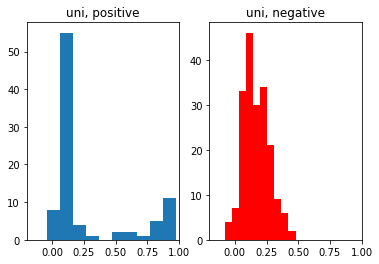

In [362]:
subplot(121)
plt.xlim([-0.2, 1.0])
plt.title("uni, positive")
plt.hist(uni_pos_scores)
subplot(122)
plt.xlim([-0.2, 1.0])
plt.title("uni, negative")
plt.hist(uni_neg_scores, color='r')

In [364]:
pos_utters[uni_pos_scores <0.2]

,spk,sent,file,set,label
rightb9f467371,b9f46737,right,b9f46737_nohash_1.wav,train,1419
sheilab9f467370,b9f46737,sheila,b9f46737_nohash_0.wav,train,1419
upb9f467370,b9f46737,up,b9f46737_nohash_0.wav,train,1419
upb9f467374,b9f46737,up,b9f46737_nohash_4.wav,train,1419
sixb9f467370,b9f46737,six,b9f46737_nohash_0.wav,train,1419
sixb9f467373,b9f46737,six,b9f46737_nohash_3.wav,train,1419
sevenb9f467372,b9f46737,seven,b9f46737_nohash_2.wav,train,1419
eightb9f467373,b9f46737,eight,b9f46737_nohash_3.wav,train,1419
oneb9f467371,b9f46737,one,b9f46737_nohash_1.wav,train,1419
stopb9f467372,b9f46737,stop,b9f46737_nohash_2.wav,train,1419


### classifier using word-level feature

In [69]:
sv_word_models = dict.fromkeys(enroll_spks)
for spk in enroll_spks:
    sv_word_models = load_model(sv_config, "models/si_{}_model.pt".format(spk))

FileNotFoundError: [Errno 2] No such file or directory: 'models/si_b9f46737_model.pt'

In [231]:
for spk in enroll_spks:
    for tag in ['train', 'val', 'test']:
        sv_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'sv_{}_{}_manifest.csv'.format(spk, tag))
    # universal feature extractor = "si_command_random_model.pt"
    print("training {}'s classifier".format(spk))
    sv_config['output_file'] = "models/sv_word_{}_model.pt".format(spk)
    # now we don't use word-level speaker models
    hk.sv_train(sv_config, spk_model=uni_spk_models[spk], model=sv_models[spk])

########### training yes word ##########
train step #1 accuracy: 1.0, loss: 0.7945159077644348
train step #2 accuracy: 0.875, loss: 0.7682243585586548
train step #3 accuracy: 0.9375, loss: 0.77701336145401
train step #4 accuracy: 0.9375, loss: 0.7763561010360718
train step #5 accuracy: 0.9375, loss: 0.7645391821861267
train step #6 accuracy: 0.875, loss: 0.7459397315979004
train step #7 accuracy: 1.0, loss: 0.7509587407112122
train step #8 accuracy: 0.9375, loss: 0.7348266839981079
train step #9 accuracy: 0.8125, loss: 0.7189040184020996
train step #10 accuracy: 1.0, loss: 0.7139837145805359
train step #11 accuracy: 1.0, loss: 0.6955537796020508
train step #12 accuracy: 0.875, loss: 0.6853870153427124
train step #13 accuracy: 1.0, loss: 0.6611524820327759
train step #14 accuracy: 0.875, loss: 0.6646353006362915
train step #15 accuracy: 0.8125, loss: 0.6645745635032654
epoch #0, final dev accuracy: 0.9833333333333333
saving best model...
train step #16 accuracy: 1.0, loss: 0.61654394865

Process Process-21075:
KeyboardInterrupt
Process Process-21078:
Process Process-21079:
Process Process-21074:


KeyboardInterrupt: 

Process Process-21073:
Process Process-21080:
Process Process-21076:
Process Process-21077:
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessi

In [177]:
sv_model

logRegModel (
  (conv1): Conv2d(1, 64, kernel_size=[20, 8], stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=[10, 4], stride=(1, 1))
  (pool2): MaxPool2d (size=(1, 1), stride=(1, 1), dilation=(1, 1))
  (bottleneck): Linear (26624 -> 256)
  (output): Linear (256 -> 2000)
  (dropout): Dropout (p = 0.5)
  (linear): Linear (1 -> 1)
)